In [190]:
from pathlib import Path
import os
import hashlib
from tqdm import tqdm

from nabstab.utils import load_model
from nabstab.datasets.classifier_dataset import pad_cdr2, pad_internal
from nabstab.constants import AA2INDEX, CDR1_NUMBERS_STR, CDR2_NUMBERS_STR, CDR3_NUMBERS_STR
import torch

from nabstab.interpretability import (
    analyze_sequence,
    compute_background_frequencies,
)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
#pdf fonts
mpl.rcParams['pdf.fonttype'] = 42

In [16]:
## Get the paths setup
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir / 'data'
checkpoints_dir = current_dir / 'model_checkpoints'
figures_dir = current_dir / 'figures'

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
cnn_model = load_model(checkpoints_dir / 'CNN/cnn_24_fc_8.pt', 'cnn', device)

In [19]:
test_df = pd.read_csv(data_dir / 'model_training_data' / 'ENN_test.csv')

In [20]:
test_df['cdr2_padded'] = test_df['CDR2'].apply(pad_cdr2)
test_df['cdr3_padded'] = test_df['CDR3'].apply(lambda x: pad_internal(x, target_len=28))
test_df['sequence'] = test_df['CDR1'] + test_df['cdr2_padded'] + test_df['cdr3_padded']

In [21]:
all_results = []

#set seed for reproducible selection
family_int_hash = (
        int(
            hashlib.sha512(
                ("deeplift_figure").encode("utf-8")
            ).hexdigest(),
            16,
        )
        % 10**8
    )
rng = np.random.default_rng(family_int_hash)
num_sequences = len(test_df)
selected_indices = rng.choice(num_sequences, size=10000, replace=False)

for idx in tqdm(selected_indices):
    #random selection
    results = analyze_sequence(
        model=cnn_model,
        sequence=test_df.iloc[idx]['sequence'],
        device=device,
        baseline_type='shuffle',
        n_shuffles=20,
        )
    
    all_results.append(results)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/akoehl/miniconda3/envs/omnilib-stability/lib/python3.10/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
100%|██████████| 10000/10000 [19:57<00:00,  8.35it/s]


In [191]:
mean_attributions = np.mean([np.array(res['attributions']) for res in all_results], axis=0)

In [228]:
np.save(figures_dir / 'deeplift_mean_attributions.npy', mean_attributions)

In [192]:
mean_attributions_nogap = mean_attributions.copy()
mean_attributions_nogap[-1, :] = 0  # Zero out gap contributions

In [193]:
cdr1 = range(0,7)
cdr2 = range(7,20)
cdr3 = range(20,48)

def plot_region(ax, data_slice, title, xticklabels =[], yticklabels = [], **kwargs):
    g = sns.heatmap(data_slice, ax=ax, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, **kwargs)
    g.set_title(title)
    g.set_xlabel('')

/tmp/ipykernel_843345/3085586907.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar


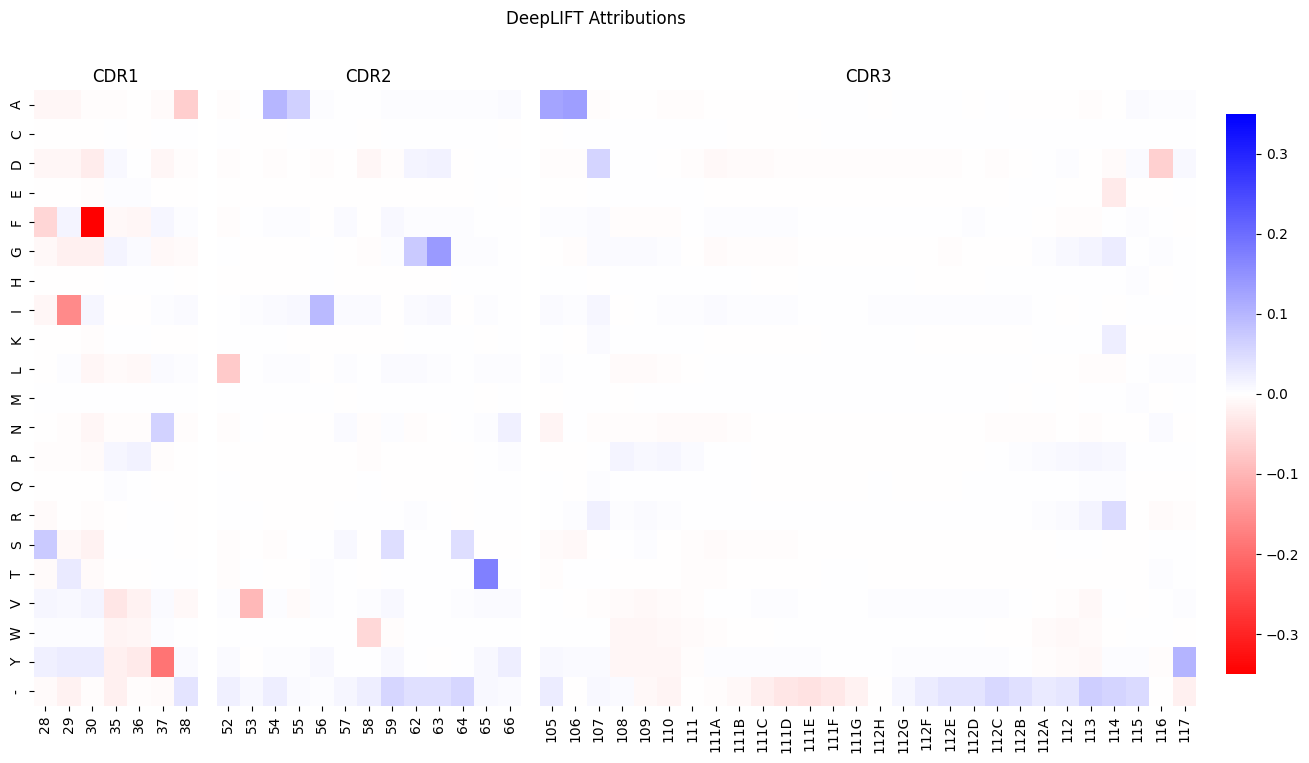

In [194]:
fig = plt.figure(figsize=(15, 8))

gs = gridspec.GridSpec(1, 3, width_ratios=[len(cdr1), len(cdr2), len(cdr3)], wspace=0.05)
plot_kwargs = {
    'cmap':'bwr_r',
    'vmin':-0.35,
    'vmax':0.35,
    'center':0,
}

ax1 = plt.subplot(gs[0])
plot_region(ax1, mean_attributions[:, cdr1], 'CDR1', xticklabels=CDR1_NUMBERS_STR, yticklabels=AA2INDEX.keys(), **plot_kwargs)

ax2 = plt.subplot(gs[1])
plot_region(ax2, mean_attributions[:, cdr2], 'CDR2', xticklabels=CDR2_NUMBERS_STR, **plot_kwargs)

ax3 = plt.subplot(gs[2])
plot_region(ax3, mean_attributions[:, cdr3], 'CDR3', xticklabels=CDR3_NUMBERS_STR, **plot_kwargs)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=90)

# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)

plt.suptitle('DeepLIFT Attributions')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar

fig.savefig(figures_dir / 'deeplift_mean_attributions_cdrs.pdf', bbox_inches='tight')
fig.savefig(figures_dir / 'deeplift_mean_attributions_cdrs.png', bbox_inches='tight', dpi=300)

/tmp/ipykernel_843345/2867515027.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar


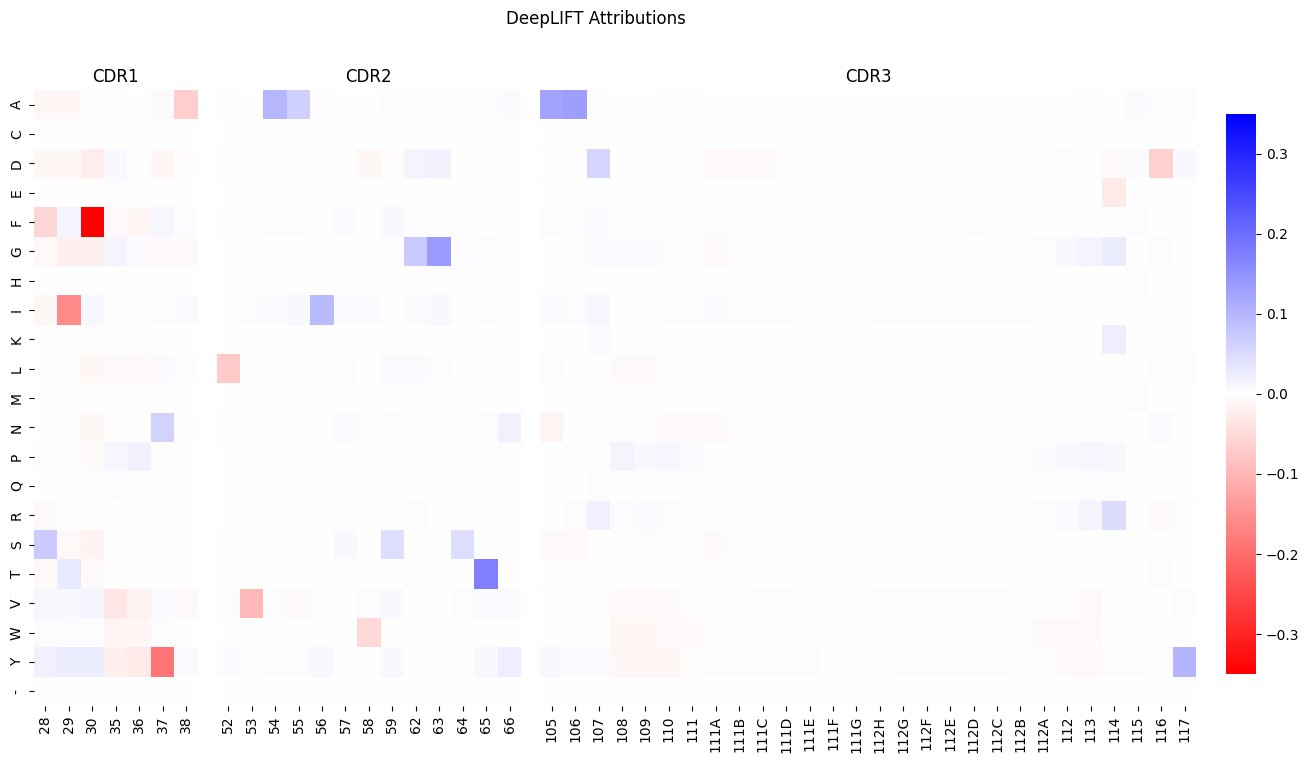

In [195]:
fig = plt.figure(figsize=(15, 8))

gs = gridspec.GridSpec(1, 3, width_ratios=[len(cdr1), len(cdr2), len(cdr3)], wspace=0.05)
plot_kwargs = {
    'cmap':'bwr_r',
    'vmin':-0.35,
    'vmax':0.35,
    'center':0,
}

ax1 = plt.subplot(gs[0])
plot_region(ax1, mean_attributions_nogap[:, cdr1], 'CDR1', xticklabels=CDR1_NUMBERS_STR, yticklabels=AA2INDEX.keys(), **plot_kwargs)

ax2 = plt.subplot(gs[1])
plot_region(ax2, mean_attributions_nogap[:, cdr2], 'CDR2', xticklabels=CDR2_NUMBERS_STR, **plot_kwargs)

ax3 = plt.subplot(gs[2])
plot_region(ax3, mean_attributions_nogap[:, cdr3], 'CDR3', xticklabels=CDR3_NUMBERS_STR, **plot_kwargs)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=90)

# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)

plt.suptitle('DeepLIFT Attributions')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar

fig.savefig(figures_dir / 'deeplift_mean_attributions_nogap_cdrs.pdf', bbox_inches='tight')
fig.savefig(figures_dir / 'deeplift_mean_attributions_nogap_cdrs.png', bbox_inches='tight', dpi=300)

In [196]:
from nabstab.datasets.classifier_dataset import NbStabilityDataset
import torch.nn.functional as F
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import jaccard

In [197]:
lr_frequency_file = '/home/akoehl/Projects/nanobody/omnilib-ml/figures/figure_4_outputs/logistic_regression_coefficients_frequency_scaled.csv'
lr_freq_df = pd.read_csv(lr_frequency_file, index_col=0)
lr_coeffs = lr_freq_df.values

In [49]:
## Get the paths setup
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir / 'data'
checkpoints_dir = current_dir / 'model_checkpoints'

In [50]:
train_set = pd.read_csv(data_dir / 'model_training_data/ENN_train.csv')
ds = NbStabilityDataset(train_set, AA2INDEX, cdr3_max_len=28)

In [198]:
sums = torch.zeros((len(AA2INDEX), ds.sequence_length))
for i in range(0, len(ds), 64):
    seqs, labels = ds[i:i+64]
    oh = F.one_hot(seqs, len(AA2INDEX)).transpose(1,2)
    sums += oh.sum(dim=0)

In [199]:
nongap_sums = sums.clone()
nongap_sums[-1, :] = 0  # Zero out gap counts

In [200]:
#get positions of top 10% of seen amino acids

flat_sums = nongap_sums.flatten()
num_top = int(0.05 * len(flat_sums))
top_indices = torch.topk(flat_sums, num_top, sorted=True).indices

In [201]:
flat_sums[top_indices].sum()/flat_sums.sum()

tensor(0.6176)

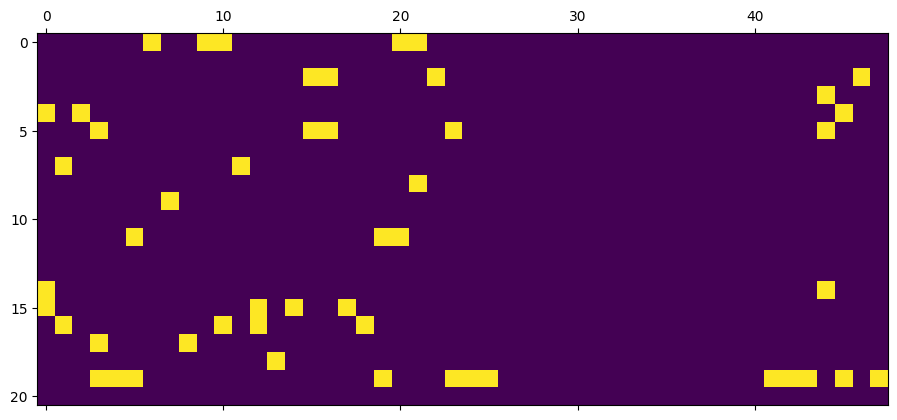

In [202]:
plt.matshow(torch.zeros_like(sums).flatten().scatter_(0, top_indices, 1).reshape(sums.shape))

In [203]:
lr_coeffs_flat = lr_coeffs.flatten()
attr_flat = mean_attributions.flatten()

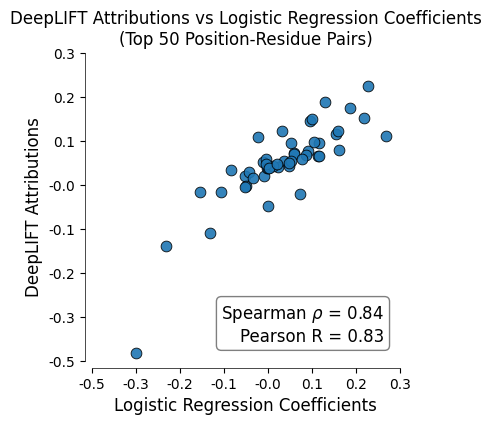

In [227]:
fig, axs = plt.subplots(figsize=(4,4))

sns.scatterplot(x=lr_coeffs_flat[top_indices], y=attr_flat[top_indices], ax=axs, zorder = 10, edgecolor='black', s=60, alpha=0.9)

axs.set_aspect('equal', 'box')
axs.set_xlabel('Logistic Regression Coefficients', fontsize=12)
axs.set_ylabel('DeepLIFT Attributions', fontsize=12)

axs.set_title('DeepLIFT Attributions vs Logistic Regression Coefficients\n(Top 50 Position-Residue Pairs)', fontsize=12)

#textbox for spearman correlation
spearman_corr = spearmanr(lr_coeffs_flat[top_indices], attr_flat[top_indices]).correlation
pearson_corr = pearsonr(lr_coeffs_flat[top_indices], attr_flat[top_indices]).correlation
textstr = '\n'.join((
    'Spearman ' + r'$\rho$' + f' = {spearman_corr:.2f}',
    f'Pearson R = {pearson_corr:.2f}',
    ))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs.text(0.95, 0.05, textstr, transform=axs.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

axs.set_xlim([-0.45, 0.25])
axs.set_ylim([-0.45, 0.25])
#set ticks 0.1 apart
axs.set_xticks(np.arange(-0.45, 0.35, 0.1), labels=[f'{x:.1f}' for x in np.arange(-0.45, 0.35, 0.1)], fontsize=12)
axs.set_yticks(np.arange(-0.45, 0.35, 0.1), labels=[f'{x:.1f}' for x in np.arange(-0.45, 0.35, 0.1)], fontsize=12)

for spline in axs.spines.values():
    spline.set_visible(True)
    spline.set_linewidth(0.5)

sns.despine(ax=axs, offset=5, trim=False)

fig.savefig(figures_dir / 'deeplift_vs_logistic_regression_top50.pdf', bbox_inches='tight')
fig.savefig(figures_dir / 'deeplift_vs_logistic_regression_top50.png', bbox_inches='tight', dpi=300)